In [3]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import feature_selec_functions
import csv

import hcp_utils as hcp

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

# Load results for plotting

In [37]:
#path to Flanker Task results
path_F = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/df_F.csv'
df_F = pd.read_csv(path_F)


In [38]:
df_F

,Unnamed: 0,node1,node2,beta
0,0,LH_Vis_1,LH_Vis_3,-0.182916
1,1,LH_Vis_1,LH_Vis_4,-0.398821
2,2,LH_Vis_3,RH_Cont_PFCl_2,0.224199
3,3,LH_Vis_4,RH_SalVentAttn_FrOperIns_1,0.330371
4,4,LH_Vis_4,RH_Cont_PFCl_2,0.214480
5,5,LH_Vis_5,LH_Cont_Par_1,0.177010
6,6,LH_Vis_5,RH_Vis_6,0.174169
7,7,LH_Vis_5,RH_Cont_PFCl_2,0.205446
8,8,LH_Vis_9,LH_SalVentAttn_Med_3,0.243878
9,9,LH_SomMot_4,LH_DorsAttn_Post_1,-0.181675


In [39]:
node_names = list(df_F.node1) + list(df_F.node2)
node_names = list(set(node_names))
con = np.abs(df_F.beta)

In [40]:
len(df_F)

49

In [32]:
name = 'RH_Default_Temp_2'
net = name.split('_')[1]
net

'Default'

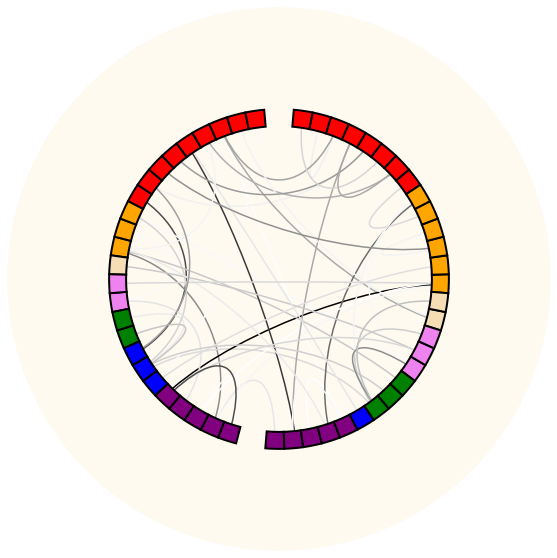

(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

In [44]:
i_1 = []
i_2 = []
for f in range(len(df_F)):
    feature = df_F.iloc[f,:]
    i_1.append(node_names.index(feature['node1']))
    i_2.append(node_names.index(feature['node2']))
indices = (np.array(i_1), np.array(i_2))

lh_names = [name for name in node_names if 'LH' in name]
rh_names = [name for name in node_names if 'RH' in name]
lh_ordered = []
rh_ordered = []
net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
for network in net_names: 
    lh_net_names = [name for name in lh_names if network in name]
    lh_ordered = lh_ordered + lh_net_names

    rh_net_names = [name for name in rh_names if network in name]
    rh_ordered = rh_ordered + rh_net_names
lh_ordered.reverse()
ordered = lh_ordered + rh_ordered

layout = circular_layout(node_names=node_names, node_order=ordered, group_boundaries=[0, len(lh_ordered)])
colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
#colors_list = [(120/255, 18/255, 133/255), (70/255, 130/255, 180/255), (0/255, 118/255, 14/255), (196/255, 57/255, 248/255), (220/255, 248/255, 162/255), (230/255, 146/255, 32/255), (204/255, 60/255, 78/255)]

color_dict = dict(zip(net_names, colors_list))
node_colors = []
for name in node_names:
    net = name.split('_')[1]
    node_colors.append(color_dict[net])
    

fig = plt.figure(figsize=[10,10], facecolor='white')
plot_connectivity_circle(np.abs(df_F.beta), node_names, indices ,fontsize_names=0, n_lines=100,
                         textcolor='floralwhite', facecolor='floralwhite', node_angles=layout, 
                        node_colors=node_colors, fig=fig, colormap='Greys', colorbar=False)